0.5386630413719787
   1.0% - 5.051e-05 m - 0.0 seconds
   2.0% - 1.010e-04 m - 0.0 seconds
   3.0% - 1.515e-04 m - 0.0 seconds
   4.0% - 2.020e-04 m - 0.0 seconds
   5.1% - 2.525e-04 m - 0.0 seconds
   6.1% - 3.030e-04 m - 0.0 seconds
   7.1% - 3.535e-04 m - 0.0 seconds
   8.1% - 4.040e-04 m - 0.0 seconds
   9.1% - 4.545e-04 m - 0.0 seconds
  10.1% - 5.051e-04 m - 0.0 seconds
  11.1% - 5.556e-04 m - 0.0 seconds
  12.1% - 6.061e-04 m - 0.0 seconds
  13.1% - 6.566e-04 m - 0.0 seconds
  14.1% - 7.071e-04 m - 0.0 seconds
  15.2% - 7.576e-04 m - 0.0 seconds
  16.2% - 8.081e-04 m - 0.1 seconds
  17.2% - 8.586e-04 m - 0.1 seconds
  18.2% - 9.091e-04 m - 0.1 seconds
  19.2% - 9.596e-04 m - 0.1 seconds
  20.2% - 1.010e-03 m - 0.1 seconds
  21.2% - 1.061e-03 m - 0.1 seconds
  22.2% - 1.111e-03 m - 0.1 seconds
  23.2% - 1.162e-03 m - 0.1 seconds
  24.2% - 1.212e-03 m - 0.1 seconds
  25.3% - 1.263e-03 m - 0.1 seconds
  26.3% - 1.313e-03 m - 0.1 seconds
  27.3% - 1.364e-03 m - 0.1 seconds
  28.3% -

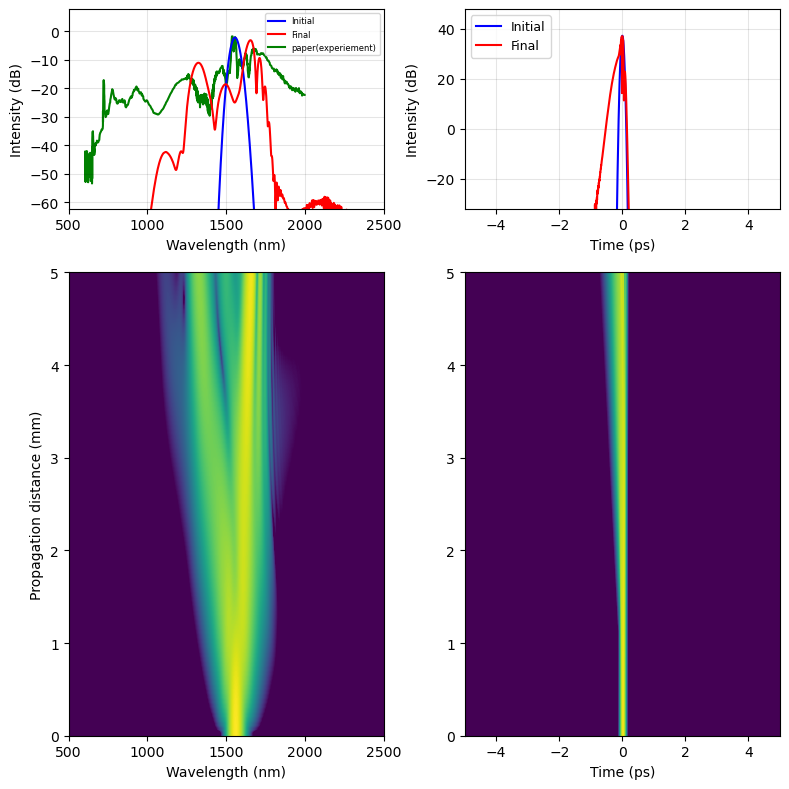

In [1]:
import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c

# pulse parameters
FWHM = 125 * 1e-3# pulse duration (ps)
pulseWL = 1555  # pulse central wavelength (nm)
length = 5 * 1e-3

epp =400e-12  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion


# simulation parameters
Window = 10  # simulation window (ps)
Steps = 100  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4  # absolute error
Raman = True  # Enable Raman effect?
Steep = True  # Enable self steepening?

# ----------- Build Waveguide -----------
n2 = 1e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0  # loss (dB/cm)

data = np.load(f"data_h_{0.2}_w_{1.3}_no.npz")
wls = data['wls']
neff_list = data['neff_list_tm']
aeff_list = data['aeff_list_tm']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (wl * 1e-9 * aeff_interp(wl) * 1e-12)
    return gamma


gamma = gamma_function(pulseWL)
print(gamma)
# create the pulse:
p = lf.Pulse(pulse_type='gaussian', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, GDD=GDD, TOD=TOD, FOD=FOD,
             npts=Points, epp=epp, power_is_avg=False, frep_MHz=100)
p.add_noise()
# create the waveguide
f = lf.Fiber(length, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma, loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)

fig, axes = results.plot(wavelength=True, show=False, tlim=(-5, 5), flim=(500, 2500), units="dB", cparam=[50, 60])
#------------- Plot reference -----------
ref = pd.read_csv(
    "../reference_data/Figure2b.csv", dtype=np.float64
)
ref_x, ref_y = np.split(ref.values, 2, axis=1)

axes[0][0].plot(ref_x, ref_y - 50, c="green", label="paper(experiement)", zorder=0)
axes[0][0].legend(loc="upper right", prop={'size': 6}, fontsize=8)

plt.set_cmap('jet')
plt.show()

[0.15904568 0.15915122 0.15925685 ... 3.27279881 3.27298347 3.27316812]


C:\Users\eliza\anaconda3\envs\SC-generation-stimulation\Lib\site-packages\pynlo\model.py:617: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self._rt_fig.show()
C:\Users\eliza\AppData\Local\Temp\ipykernel_26236\3799232377.py:87: RuntimeWarning: divide by zero encountered in log10
  p_t_dB = 10 * np.log10(np.abs(a_t) ** 2)
C:\Users\eliza\AppData\Local\Temp\ipykernel_26236\3799232377.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


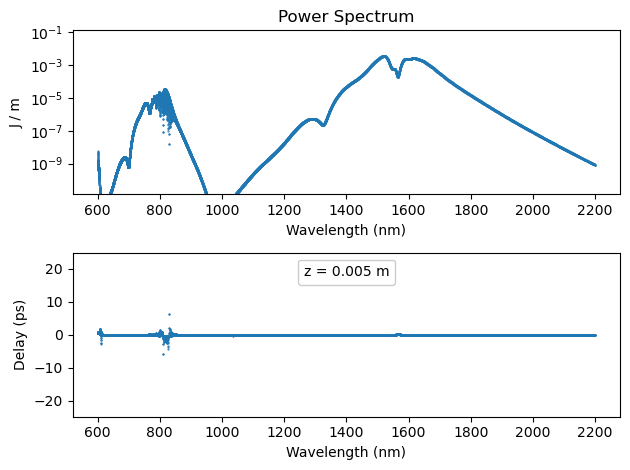

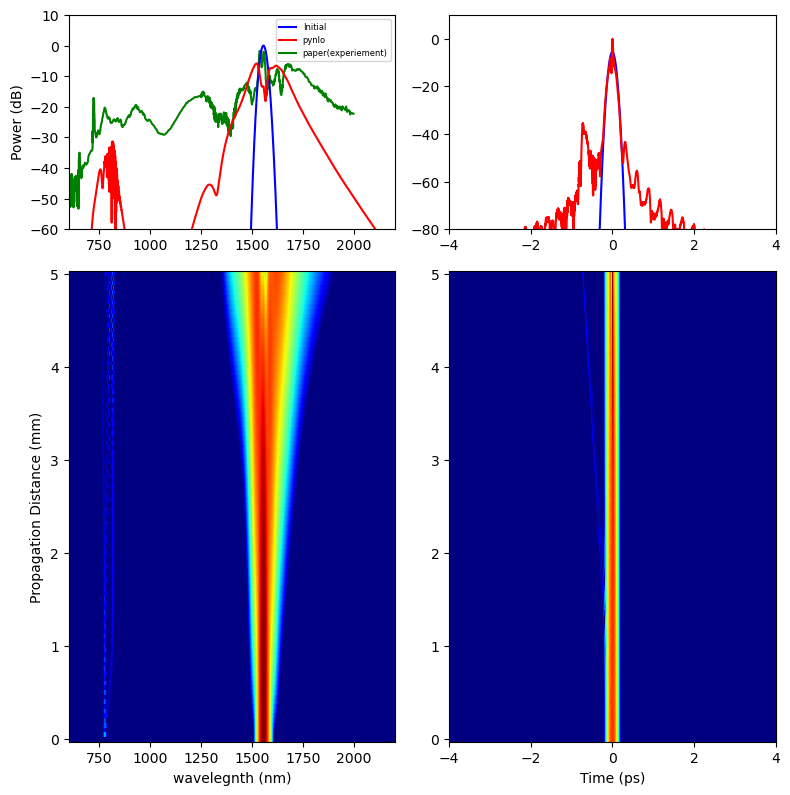

In [2]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi, c
from matplotlib import pyplot as plt

import pynlo
from pynlo import utility as ut

# pulse parameters
n_points = 2 ** 14
center_wl = 1555 * 1e-9
start_wl = 600 * 1e-9
end_wl = 2200 * 1e-9

e_p = 400e-12  # energy per pulse in joules
t_fwhm = 125e-15  # for sech, fwhm = 1.76 * pulse duration 

f_min = c / (end_wl)  # c / l
f_max = c / (start_wl)  # c / l
f0 = c / center_wl  # c / 

pulse = pynlo.light.Pulse.Gaussian(n_points, f_min, f_max, f0, e_p, t_fwhm,
                               alias=2)  # alias = number of harmonic support by the real-valued time domain grid

wls = data['wls'] * 1e-9
aeff_list = data['aeff_list_tm']
neff_list = data['neff_list_tm']

aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
neff_interp = scipy.interpolate.interp1d(wls, neff_list)

length = 5e-3  # 10 mm
a_eff = aeff_interp(center_wl) * 1e-12

#---- Phase Coefficient
w_grid = c / pulse.v_grid
n_eff = neff_interp(w_grid)
beta = n_eff * 2 * pi * pulse.v_grid / c

#---- 2nd-order nonlinearity
chi2_eff = 30e-12 * 2  # pm / V
g2 = ut.chi2.g2_shg(f0, pulse.v_grid, n_eff, a_eff, chi2_eff)

# 3rd-Order Nonlinearity
n2 = 1e-19


def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * aeff_interp(pump_wl) * 1e-12)
    return gamma


gamma = gamma_function(w_grid)  #1/(W*m)
print(gamma)
g3 = ut.chi3.gamma_to_g3(pulse.v_grid, gamma)

mode = pynlo.medium.Mode(pulse.v_grid, beta, g3=g3, g2=g2)

#----build model
model = pynlo.model.UPE(pulse, mode)

#---- Estimate step size
local_error = 1e-6
dz = model.estimate_step_size(local_error=local_error)

pulse_out, z, a_t, a_v = model.simulate(length, dz=dz, local_error=local_error, n_records=100, plot="wvl")

fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, sharex=ax1)

p_v_dB = 10 * np.log10(np.abs(a_v) ** 2)
p_v_dB -= p_v_dB.max()

w_grid = c / (pulse.v_grid) * 1e9
ax0.plot(w_grid, p_v_dB[0], color="b", label='Initial')
ax0.plot(w_grid, p_v_dB[-1], color="r", label="pynlo")
ax2.pcolormesh(w_grid, 1e3 * z, p_v_dB,
               vmin=-40.0, vmax=0, shading="auto", cmap="jet")
ax0.set_ylim(bottom=-60, top=10)
ax2.set_xlabel('wavelegnth (nm)')

p_t_dB = 10 * np.log10(np.abs(a_t) ** 2)
p_t_dB -= p_t_dB.max()
ax1.plot(1e12 * pulse.t_grid, p_t_dB[0], color="b", label='Initial')
ax1.plot(1e12 * pulse.t_grid, p_t_dB[-1], color="r")
ax3.pcolormesh(1e12 * pulse.t_grid, 1e3 * z, p_t_dB,
               vmin=-40.0, vmax=0, shading="auto")

ax1.set_ylim(bottom=-80, top=10)
ax1.set_xlim(-4, 4)
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Power (dB)')
ax2.set_ylabel('Propagation Distance (mm)')
#------------- Plot reference -----------

ref = pd.read_csv(
    "../reference_data/Figure2b.csv", dtype=np.float64
)
ref_x, ref_y = np.split(ref.values, 2, axis=1)

ax0.plot(ref_x, ref_y - 50, c="green", label="paper(experiement)", zorder=0)
ax0.legend(loc="upper right", prop={'size': 6}, fontsize=8)

fig.tight_layout()
fig.show()